In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload
# Always reload modules so that as you change code in src, it gets loaded
%autoreload

# %%capture --no-display
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
import pandas as pd
from KDEpy import FFTKDE  # Fastest 1D algorithm

from src.DDM import *
from src.IAM import *
from src.dynamic_parameters import *
from src.likelihood_estimation import *

data_path = "./../data/"
df = pd.read_csv(data_path + 'rt_data.csv')
data = df['rt_data'].to_numpy()


In [7]:
def get_llh_PDE(RT_model, RT_data, kernal='gaussian', bandwidth='silverman'):
    """
    Takes reaction time distribution of model and data and calculated negative log likelihood based on the Probability Density Estimation.
    
    Args: 
        RT_model:  Reaction time data from model simulation in msec. Type: array(1D, float32)
        RT_data:   Reaction time data from experimental data in msec. Type: array(1D, float32)
        kernal:    Choose kernel for PDE estimation. Available options:
                   ['gaussian', 'exponential', 'box', 'tri', 'epa', 'biweight', 'triweight', 'tricube', 'cosine']
                   Default: 'gaussian' kernel
        bandwidth: 
        
    Return:
        nLLh: Negatively log likelihood of the data given model parameters
    """
 
    if "FFTKDE" not in dir():
        raise ValueError('You have not imported FFTKDE from KDEpy')
        
    if kernel not in FFTKDE._available_kernels.keys():
        raise ValueError('Specified kernel not in package. Please use one of following kernels: \n [\'gaussian\', \'exponential\', \'box\', \'tri\', \'epa\', \'biweight\', \'triweight\', \'tricube\', \'cosine\']')
    
    if not str(bandwidth).isnumeric() or bandwidth not in FFTKDE._bw_methods.keys():
        raise ValueError('Specified bandwidth not applicable. Please either use number of \n automatically choose with one of the following method: \n [\'silverman\', \'scott\', \'ISJ\'] \n Default value: \'silverman\' ')
    
    
    RT_range = np.arange(np.max(np.concatenate((RT_data,RT_model))) + 1)
    PDE_model = FFTKDE(kernel=kernel, bw=bandwidth).fit(RT_model).evaluate(RT_range)
    PDE_data = FFTKDE(kernel='gaussian', bw='silverman').fit(RT_data).evaluate(RT_range)
    N_data = PDE_data * len(RT_data)  # Converting probability to total number of trials  

    likelihood = (PDE_model ** N_data) + 1e-24   # Calculating likelihood and offseting by small number to avoid calculation of log(0)
    nLLh = sum(-log(likelihood))    
    return nLLh

In [259]:
def get_llh_QMLE(RT_model, RT_data, nbins=9):
    """
    Takes reaction time distribution of model and data and calculated negative log likelihood based on the Quasi-Maximum Likelihood Estimate (QMLE).
    
    Args: 
        RT_model: Reaction time data from model simulation in msec. Type: array(1D, float32)
        RT_data: Reaction time data from experimental data in msec. Type: array(1D, float32)
        nbins: Quantized bins. Default value is 9.
        
    Return:
        nLLh: Negatively log likelihood of the data given model parameters
        
    """
    
    if nbins > len(RT_model):        
        raise ValueError('Number of bins cannot be more than number samples')
         
    quantile = np.arange(0, 1+1e-10, 1/nbins)
    nTrials = len(RT_data)
    trials_per_quantile = np.diff(quantile) * nTrials
    quantile_estimate = np.zeros(nbins+1)*np.nan
    QML = np.zeros(nbins)*np.nan

    quantile_estimate[0] = min(RT_data)
    quantile_estimate[-1] = max(RT_data)

    for bin_num in range(1,nbins):
        centre = (quantile[bin_num]*nTrials) + 0.5
        prev_edge = int(np.floor(centre))
        next_edge = int(np.ceil(centre))
        quantile_estimate[bin_num] = RT_data[prev_edge-1] + (RT_data[next_edge-1] - RT_data[prev_edge-1]) * (centre - prev_edge)

    for bin_num in range(0,nbins):
        likelihood = np.mean(np.logical_and(RT_model>=quantile_estimate[bin_num], RT_model<quantile_estimate[bin_num+1])) ** trials_per_quantile[bin_num]
        QML[bin_num] = -log(likelihood + 1e-24)   # Offseting likelihood by small number to avoid calculation of log(0)   
    nLLh = sum(QML)
    
    return nLLh



In [3]:

RT_data = np.arange(1,3,1/100)
RT_model = np.arange(2.1,4,1/100)
print(get_llh_QMLE(RT_model, RT_data, nbins=20))
print(get_llh_PDE(RT_model, RT_data))

RT_data = np.arange(2,4,1/100)
RT_model = np.arange(2.1,4,1/100)
print(get_llh_QMLE(RT_model, RT_data, nbins=20))
print(get_llh_PDE(RT_model, RT_data))


872.8819726753522
108.24323806250888
615.7590534299311
105.91569944580029


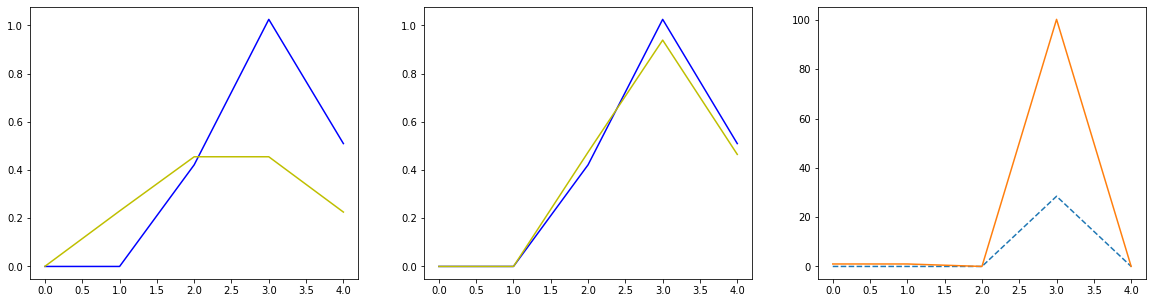

In [5]:

fig, ax = plt.subplots(1,3,figsize=(20,5))
RT_data = np.arange(1,4,1/100)
RT_model = np.arange(2.1,4,1/100)
RT_range = np.arange(np.max(RT_data)+1)
PDE_model = FFTKDE(kernel='gaussian', bw='silverman').fit(RT_model).evaluate(RT_range)
PDE_data = FFTKDE(kernel='gaussian', bw='silverman').fit(RT_data).evaluate(RT_range)
N_data = PDE_data * len(RT_data)  # Converting probability to total number of trials  
likelihood = (PDE_model ** N_data)
ax[0].plot(PDE_model,'b')
ax[0].plot(PDE_data,'y')
ax[2].plot(likelihood,'--')

RT_data = np.arange(2,4,1/100)
RT_model = np.arange(2.1,4,1/100)
RT_range = np.arange(np.max(RT_data)+1)
PDE_model = FFTKDE(kernel='gaussian', bw='silverman').fit(RT_model).evaluate(RT_range)
PDE_data = FFTKDE(kernel='gaussian', bw='silverman').fit(RT_data).evaluate(RT_range)
N_data = PDE_data * len(RT_data)  # Converting probability to total number of trials  
likelihood = (PDE_model ** N_data)
ax[1].plot(PDE_model,'b')
ax[1].plot(PDE_data,'y')
ax[2].plot(likelihood,'-')
